Streaming output truncated to the last 5000 lines.
4 [D loss: 0.041181358052654105, accuracy: 100.00] [G loss: 0.4171830713748932]
5 [D loss: 0.012376319275062997, accuracy: 100.00] [G loss: 0.35346904397010803]
6 [D loss: 0.011111020942735195, accuracy: 100.00] [G loss: 0.30084168910980225]
7 [D loss: 0.013490420024027117, accuracy: 100.00] [G loss: 0.3057456314563751]
8 [D loss: 0.0071923966315807775, accuracy: 100.00] [G loss: 0.2680428624153137]
9 [D loss: 0.006748657004209235, accuracy: 100.00] [G loss: 0.3033844828605652]
10 [D loss: 0.01410936564207077, accuracy: 100.00] [G loss: 0.3320600688457489]
11 [D loss: 0.04117632191628218, accuracy: 100.00] [G loss: 0.3766770362854004]
12 [D loss: 0.005377183057134971, accuracy: 100.00] [G loss: 0.34976887702941895]
13 [D loss: 0.01991700823418796, accuracy: 100.00] [G loss: 0.4251692295074463]
14 [D loss: 0.41279284469783306, accuracy: 72.66] [G loss: 1.3334850072860718]
15 [D loss: 0.009909944041935681, accuracy: 100.00] [G loss: 2.47

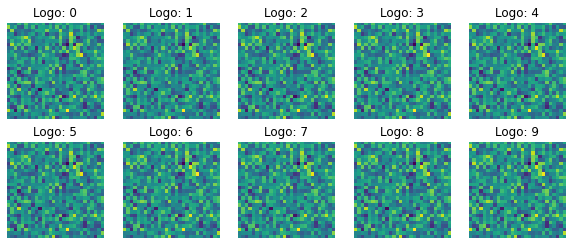

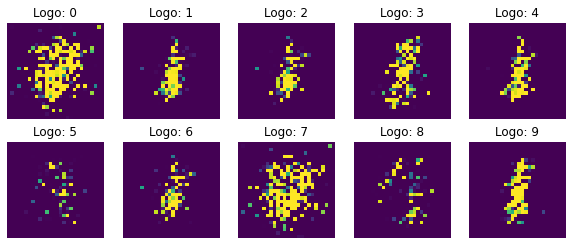

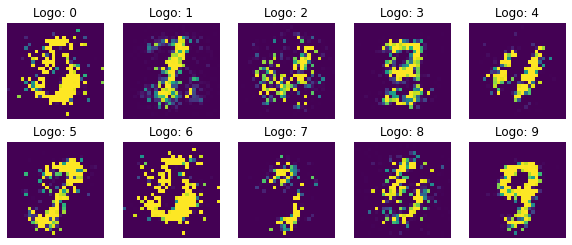

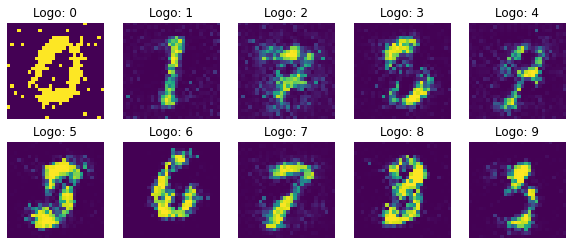

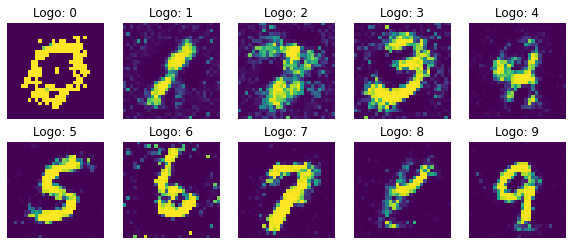

In [3]:
from keras import backend as K
from google.colab import drive
import h5py
drive.mount('/content/drive')
from keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
#dataset=h5py.File('/content/drive/My Drive/LLD-icon.hdf5')
%matplotlib inline
img_shape = (28, 28, 1)
z_dim = 100
num_classes = 10
kl=0
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256,input_shape=(z_dim,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape),activation='tanh'))
    model.add(Reshape(img_shape))
    z = Input(shape=(z_dim, ))
    
    # Conditioning label
    label = Input(shape=(1,), dtype='int32')
    
    # embedding layer:
    # turns labels into dense vectors of size z_dim
    # produces 3D tensor with shape: (batch_size, 1, z_dim)
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    
    # Flatten the embedding 3D tensor into 2D  tensor with shape: (batch_size, z_dim)
    label_embedding = Flatten()(label_embedding)
    
    # Element-wise product of the vectors z and the label embeddings
    joined_representation = multiply([z, label_embedding])
    
    img = model(joined_representation)
    
    return Model([z, label], img)
def build_discriminator(img_shape):
    #print(img_shape)
    model = Sequential()
    model.add(Flatten(input_shape=(28,28,2)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    
    img = Input(shape=img_shape)
    
    label = Input(shape=(1,), dtype='int32')
    
    # embedding layer:
    # turns labels into dense vectors of size 32*32*3
    # produces 3D tensor with shape: (batch_size, 1, 32*32*3)
    label_embedding = Embedding(input_dim=num_classes, output_dim=np.prod(img_shape), input_length=1)(label)
    # Flatten the embedding 3D tensor into 2D  tensor with shape: (batch_size, 32*32*3)
    label_embedding = Flatten()(label_embedding)
    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(img_shape)(label_embedding)
    
    # concatenate images with corresponding label embeddings
    concatenated = Concatenate(axis=-1)([img, label_embedding])
    
    prediction = model(concatenated)
    
    return Model([img, label], prediction)
# building and compiling the Discriminator
disc = build_discriminator(img_shape)
disc.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(0.001,0.5))

# build the generator
gen = build_generator(z_dim)

# the generator takes noise and the target label as input
# and generates the corresponding digit for that label
z = Input(shape=(z_dim,))
label = Input(shape=(1,))

img = gen([z, label])

# keep the discriminator's params constant for generator training
disc.trainable = False

prediction = disc([img, label])

# Conditional (Conditional) GAN model with fixed discriminator to train the generator
cgan = Model([z, label], prediction)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())
def sample_images(image_grid_rows=2, image_grid_columns=5):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = gen.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10,4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0])
            axs[i,j].axis('off')
            axs[i,j].set_title("Logo: %d" % labels[cnt])
            cnt += 1
    fig.savefig("/content/drive/My Drive/samples/epochmnist-%d"%kl)            
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, y_train),(_,_)=mnist.load_data()
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1))
    
    for iteration in range(iterations):
        kl=iterations
        idx = np.random.randint(0,X_train.shape[0], batch_size)
        imgs=np.zeros((batch_size,28,28,1),dtype=float)
        labels=np.zeros((batch_size,1),dtype=float)
        j=0;
        for i in idx:
          imgs[j]=(X_train[i]-127.5)/127.5
          labels[j]=y_train[i]
          j=j+1
        z = np.random.normal(0, 1, size=(batch_size, z_dim))
        gen_imgs = gen.predict([z, labels])
        
        d_loss_real = disc.train_on_batch([imgs, labels], real)
        d_loss_fake = disc.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, size=(batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        
        g_loss = cgan.train_on_batch([z, labels], real)
        print('{} [D loss: {}, accuracy: {:.2f}] [G loss: {}]'.format(iteration, d_loss[0], 100 * d_loss[1], g_loss))
        losses.append((d_loss[0], g_loss))
        if iteration % sample_interval == 0:
            print('{} [D loss: {}, accuracy: {:.2f}] [G loss: {}]'.format(iteration, d_loss[0], 100 * d_loss[1], g_loss))
        
            losses.append((d_loss[0], g_loss))
            accuracies.append(d_loss[1])
            
            sample_images()
iterations = 5000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)
